In [52]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the code."></form>''')

# WeRateDogs: Act report


## Introduction
WeRateDogs is a very popular Twitter account which rates dogs with a unique rating system and hilarious comments. In this report, I'll focus on the following features and analyze how they affect the ratings, retweet and favorite count.
- gender: dog's gender
- is_dog: `0` if WeRateDogs says it's not a dog else `1`
- is_animal: `0` if WeRateDogs says there's no dog in the picture else `1`

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import tweepy
import json
import requests
import cv2
import io
import os
import re
from tqdm import tqdm

pd.set_option('display.max_colwidth', -1)
sns.set()
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)

In [54]:
df = pd.read_csv('data/twitter_archive_master.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

## gender

In [55]:
ratio_female = (df['gender'] == 'female').mean()
ratio_male = (df['gender'] == 'male').mean()
ratio_unknown = 1 - (ratio_female + ratio_male)
print('Female ratio:', round(ratio_female, 2), '%')
print('Male ratio:', round(ratio_male, 2), '%')
print('Gender unknown:', round(ratio_unknown, 2), '%')

Female ratio: 0.17 %
Male ratio: 0.51 %
Gender unknown: 0.32 %


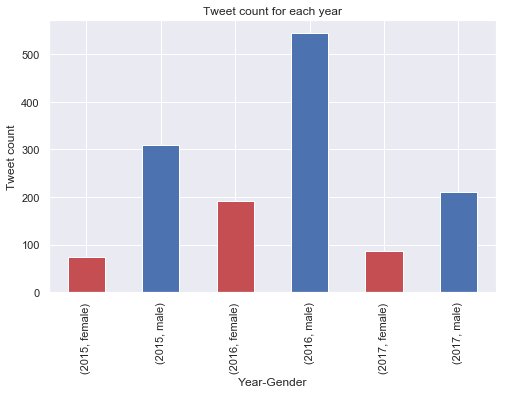

In [56]:
twt_cnt = df.groupby([df['timestamp'].dt.year, 'gender']).size()
twt_cnt.plot.bar(color=['r', 'b']*3)
plt.title('Tweet count for each year')
plt.xlabel('Year-Gender')
plt.ylabel('Tweet count');

The number of male dogs is much larger than that of female dogs for each year. WeRageDogs tweets about dog's cute and funny behavior. Are male dogs more likely to do something cute and funny or does WeRateDogs like male dogs? 

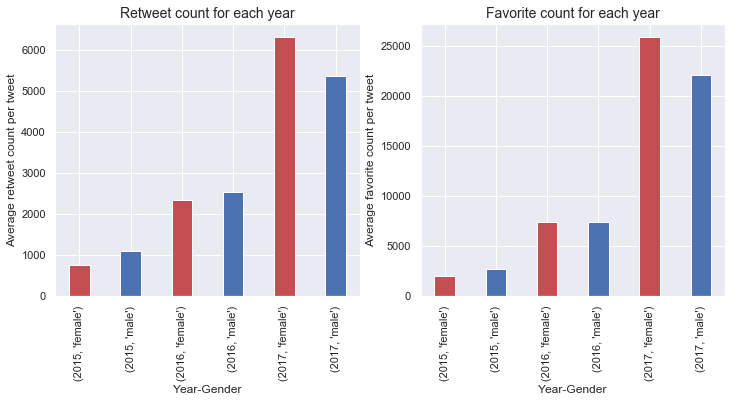

In [57]:
def plot_bar(ax, ser, xlabel, ylabel, title, xticklabels=None, color=['r', 'b'], rotation=0):
    """Helper function to plot a bar chart"""
    x = np.arange(len(ser))
    xticklabels = xticklabels if xticklabels else ser.index
    ax.bar(x, ser, color=color*int(len(ser) / 2), width=0.4)
    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels, rotation=rotation)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

ret_ave = df.groupby([df['timestamp'].dt.year, 'gender']).mean()['retweet_count']
fav_ave = df.groupby([df['timestamp'].dt.year, 'gender']).mean()['favorite_count']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
plot_bar(ax1, ret_ave, 'Year-Gender', 'Average retweet count per tweet', 'Retweet count for each year', rotation=90)
plot_bar(ax2, fav_ave, 'Year-Gender', 'Average favorite count per tweet', 'Favorite count for each year', rotation=90)

- The average retweet and favorite count per tweet is increasing year by year. This means the popularity of WeRateDogs is increasing.
- In 2017, female dogs have more retweet and favorites.

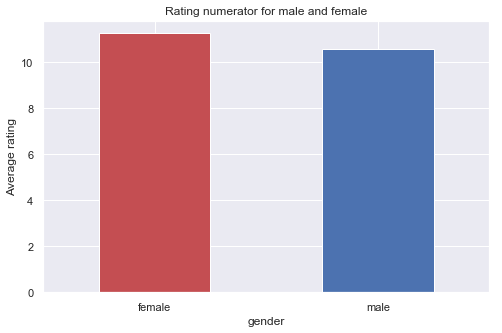

In [58]:
# Remove outliers? in rating_numerator
df['rating_numerator_clean'] = df['rating_numerator'].apply(lambda x: x if x <= 15 else np.nan)

df.groupby('gender').mean()['rating_numerator_clean'].plot.bar(color=['r', 'b'])
plt.xticks(rotation=0)
plt.ylabel('Average rating');
plt.title('Rating numerator for male and female');

- The average rating is over 10.
- Male dogs have a slightly higher ratings compared to male dogs. 

##  is_dog

In [59]:
twt_cnt = df.groupby('is_dog').size()
twt_cnt

is_dog
0    54  
1    2043
dtype: int64

54 non-dog animals are included in this dataset.

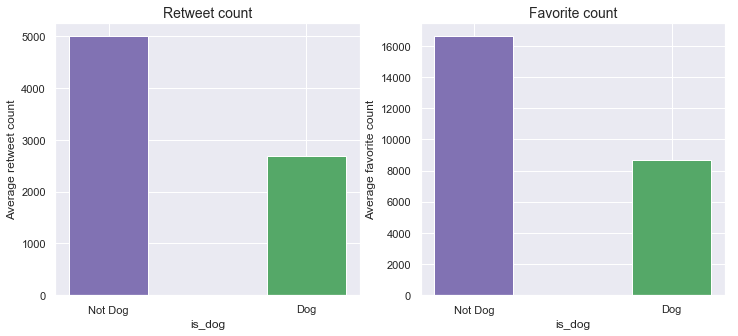

In [60]:
ret_ave = df.groupby('is_dog').mean()['retweet_count']
fav_ave = df.groupby('is_dog').mean()['favorite_count']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
plot_bar(ax1, ret_ave, 'is_dog', 'Average retweet count', 'Retweet count', xticklabels=['Not Dog', 'Dog'], color=['m', 'g'])
plot_bar(ax2, fav_ave, 'is_dog', 'Average favorite count', 'Favorite count', xticklabels=['Not Dog', 'Dog'], color=['m', 'g'])

Animals that are not dogs have about twice more retweets and favorites! This makes sense because the best part of WeRateDogs is when it rates non-dog animals (they are actually dogs most of time) with hilarious comments.

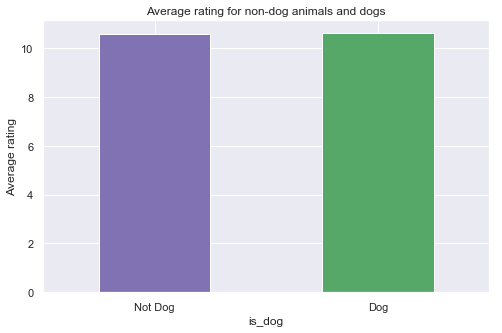

In [61]:
df.groupby('is_dog').mean()['rating_numerator_clean'].plot.bar(color=['m', 'g'])
plt.xticks(plt.xticks()[0], ['Not Dog', 'Dog'], rotation=0)
plt.ylabel('Average rating')
plt.title('Average rating for non-dog animals and dogs');

They look almost the same. So we can conclude that WeRateDogs gives a fair rating for non-dog animals even though it always complains when people send them.

## is_animal

In [62]:
df[df['is_animal'] == 0][['tweet_id', 'text']]

,tweet_id,text
97,870804317367881728,Real funny guys. Sending in a pic without a dog in it. Hilarious. We'll rate the rug tho because it's giving off a very good vibe. 11/10 https://t.co/GCD1JccCyi
628,771014301343748096,Another pic without a dog in it? What am I supposed to do? Rate the carpet? Fine I will. 7/10 looks adequately comfy https://t.co/OJZQ6I4gGd
708,757596066325864448,Here's another picture without a dog in it. Idk why you guys keep sending these. 4/10 just because that's a neat rug https://t.co/mOmnL19Wsl
779,748977405889503236,What jokester sent in a pic without a dog in it? This is not @rock_rates. This is @dog_rates. Thank you ...10/10 https://t.co/nDPaYHrtNX
1247,693647888581312512,What kind of person sends in a pic without a dog in it? So churlish. Neat rug tho 7/10 https://t.co/LSTAwTdTaw
1625,675153376133427200,What kind of person sends in a picture without a dog in it? 1/10 just because that's a nice table https://t.co/RDXCfk8hK0


There are 6 tweets where WeRateDogs says there is no dog in the picture.

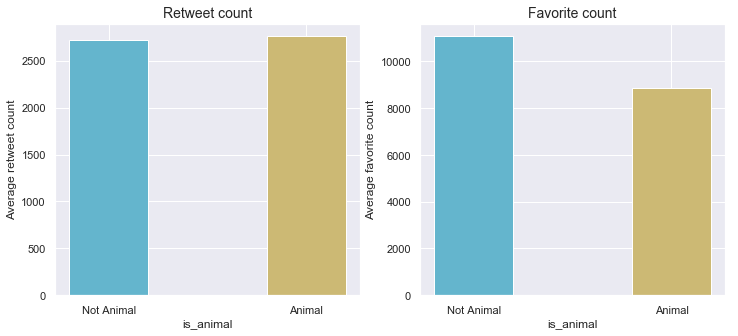

In [63]:
ret_ave = df.groupby('is_animal').mean()['retweet_count']
fav_ave = df.groupby('is_animal').mean()['favorite_count']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
plot_bar(ax1, ret_ave, 'is_animal', 'Average retweet count', 'Retweet count', xticklabels=['Not Animal', 'Animal'], color=['c', 'y'])
plot_bar(ax2, fav_ave, 'is_animal', 'Average favorite count', 'Favorite count', xticklabels=['Not Animal', 'Animal'], color=['c', 'y'])

Text(0.5,1,'Average rating for non-dog animals and dogs')

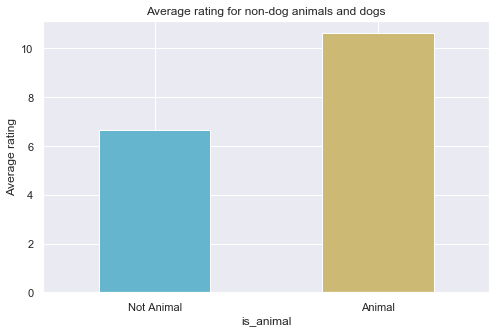

In [64]:
df.groupby('is_animal').mean()['rating_numerator_clean'].plot.bar(color=['c', 'y'])
plt.xticks(plt.xticks()[0], ['Not Animal', 'Animal'], rotation=0)
plt.ylabel('Average rating')
plt.title('Average rating for non-dog animals and dogs')

The reliability of these results is skeptical because the number of samples in 'without_dog' is only 6 which is very small. But pictures without a dog in it tend to get rated very low even though they get more favorates.

# Conclusion
1. WeRateDogs often tweets male dogs.
1. The popularity of WeRateDogs is increasing. 
2. Non-dog animals are likely to get more retweets and favoriates than dogs.
2. WeRateDogs is a fair rater even for non-dog animals, but very strict with people sending in pictures without a dog in it.
